In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import numpy as np
import pandas as pd 

from whatlies import Embedding, EmbeddingSet
from whatlies.transformers import Pca
from whatlies.language import FasttextLanguage, SpacyLanguage, BytePairLanguage

In [3]:
lang_ft = FasttextLanguage("cc.en.300.bin")
lang_sp = SpacyLanguage("en_core_web_md")

In [8]:
lang_ft.score_similar(lang_ft['king'], n=10, metric='cosine')

[(Emb[king], 0.0),
 (Emb[kings], 0.2449641227722168),
 (Emb[queen], 0.2931479215621948),
 (Emb[King], 0.3408734202384949),
 (Emb[prince], 0.35047459602355957),
 (Emb[royal], 0.41696715354919434),
 (Emb[throne], 0.42722034454345703),
 (Emb[kingdom], 0.434279203414917),
 (Emb[emperor], 0.44683873653411865),
 (Emb[lord], 0.4479447603225708)]

In [9]:
lang_ft.score_similar(lang_ft['king'] - lang_ft['man'] + lang_ft['woman'], n=10, metric='cosine')

[(Emb[king], 0.2713325619697571),
 (Emb[queen], 0.3457321524620056),
 (Emb[kings], 0.45897185802459717),
 (Emb[Queen], 0.49255800247192383),
 (Emb[royal], 0.49954700469970703),
 (Emb[King], 0.5179671049118042),
 (Emb[throne], 0.554189920425415),
 (Emb[princess], 0.5551300048828125),
 (Emb[prince], 0.6072607636451721),
 (Emb[palace], 0.623775064945221)]

In [11]:
lang_ft.score_similar(lang_ft['king'] - lang_ft['cat'] + lang_ft['cats'], n=10, metric='cosine')

[(Emb[king], 0.2949146628379822),
 (Emb[kings], 0.33092421293258667),
 (Emb[King], 0.5105577707290649),
 (Emb[queen], 0.5385150909423828),
 (Emb[Kings], 0.5838595628738403),
 (Emb[rulers], 0.5840845108032227),
 (Emb[kingdom], 0.5844190120697021),
 (Emb[armies], 0.5963489413261414),
 (Emb[royal], 0.6078634262084961),
 (Emb[throne], 0.6091011166572571)]

In [10]:
lang_ft.score_similar(lang_ft['king'] - lang_ft['slow'] + lang_ft['fast'], n=10, metric='cosine')

[(Emb[king], 0.20691156387329102),
 (Emb[kings], 0.3835362195968628),
 (Emb[queen], 0.45022904872894287),
 (Emb[King], 0.45194685459136963),
 (Emb[prince], 0.48818516731262207),
 (Emb[royal], 0.5023854970932007),
 (Emb[kingdom], 0.5079109072685242),
 (Emb[throne], 0.5353788137435913),
 (Emb[emperor], 0.5441315174102783),
 (Emb[princess], 0.5490601658821106)]

<br><br><br><br><br>

In the cells below we'll write some functions to make our lives just slightly easier.

In [6]:
def to_dataf(emb_list_before, emb_list_after):
    """Turns before/after Embedding score-lists into a single dataframe."""
    names_before = [_[0].name for _ in emb_list_before]
    scores_before = [_[1] for _ in emb_list_before]
    names_after = [_[0].name for _ in emb_list_after]
    scores_after = [_[1] for _ in emb_list_after]
    res = pd.DataFrame({'before_word': names_before, 
                        'before_score': scores_before, 
                        'after_word': names_after,
                        'after_score': scores_after})
    return (res
            .assign(before_score=lambda d: np.round(d['before_score'], 4))
            .assign(after_score=lambda d: np.round(d['after_score'], 4)))

def retreive_most_similar(lang, start, positive=(), negative=(), orthogonal=(), unto=(), n=10, metric='cosine'):
    """Utility function to quickly perform arithmetic and get an overview."""
    start_emb = lang[start]
    base_dist = lang.score_similar(start_emb, n=10, metric=metric)
    for pos in positive:
        start_emb = start_emb + lang[pos]
    for neg in negative:
        start_emb = start_emb - lang[neg]
    for ort in orthogonal:
        start_emb = start_emb - lang[ort]
    for un in unto:
        start_emb = start_emb - lang[un]
    proj_dist = lang.score_similar(start_emb, n=10, metric=metric)
    return to_dataf(base_dist, proj_dist)

In [7]:
retreive_most_similar(lang_sp, start="king", positive=["woman"], negative=["man"])

,before_word,before_score,after_word,after_score
0,king,0.0000,king,0.1976
1,kings,0.2123,queen,0.2119
2,princes,0.2123,prince,0.3599
3,prince,0.2662,kings,0.3791
4,queen,0.2747,princes,0.3791
5,scepter,0.3274,princess,0.3874
6,throne,0.3274,princesses,0.3874
7,kingdoms,0.3396,mermaid,0.3874
8,kingdom,0.3396,royal,0.4199
9,lord,0.3560,royals,0.4199


In [8]:
retreive_most_similar(lang_sp, start="king", positive=["woman"], negative=["man"], metric='euclidean')

,before_word,before_score,after_word,after_score
0,king,0.0000,king,4.8034
1,kings,4.6444,queen,4.9244
2,princes,4.6444,prince,6.2725
3,prince,5.0195,kings,6.5993
4,queen,5.1864,princes,6.5993
5,scepter,5.7722,princess,6.6475
6,throne,5.7722,princesses,6.6475
7,kingdoms,5.7926,mermaid,6.6475
8,kingdom,5.7926,queens,6.7349
9,lord,5.9073,royal,6.8369


This one is particularily interesting. After calculating $v_{king} - v_{man} + v_{woman}$ it seems that relatively we might be "more" similar to $v_{queen}$ than before but the absolute distance has increased.

In [9]:
retreive_most_similar(lang_ft, start="king", positive=["woman"], negative=["man"], metric='cosine')

,before_word,before_score,after_word,after_score
0,king,0.0000,king,0.2713
1,kings,0.2450,queen,0.3457
2,queen,0.2931,kings,0.4590
3,King,0.3409,Queen,0.4926
4,prince,0.3505,royal,0.4995
5,royal,0.4170,King,0.5180
6,throne,0.4272,throne,0.5542
7,kingdom,0.4343,princess,0.5551
8,emperor,0.4468,prince,0.6073
9,lord,0.4479,palace,0.6238


So what is happening here? Let's try some more arithmetic. Can we at least confirm that king - man + woman - queen = 0?

In [10]:
lang_ft['king'].norm, lang_ft['queen'].norm, lang_ft['man'].norm, lang_ft['woman'].norm

(1.5576003, 1.3054631, 1.751094, 1.0092078)

In [11]:
(lang_ft['king'] - lang_ft['queen']).norm

1.1205987

In [12]:
(lang_ft['king'] - lang_ft['man'] + lang_ft['woman'] - lang_ft['queen']).norm

1.2525381

The remainder distance from the original is larger than the distance from the origin to "woman". We could wonder ... what are similar words then? 

In [13]:
lang_ft.score_similar(lang_ft['king'] - lang_ft['man'] + lang_ft['woman'] - lang_ft['queen'], metric='cosine')

[(Emb[king], 0.791412353515625),
 (Emb[Libraries], 0.7980725765228271),
 (Emb[Resolution], 0.800546407699585),
 (Emb[CE], 0.8015693426132202),
 (Emb[Curriculum], 0.8188096284866333),
 (Emb[Distance], 0.8230936527252197),
 (Emb[Availability], 0.82375168800354),
 (Emb[Approved], 0.8281855583190918),
 (Emb[VMware], 0.833002507686615),
 (Emb[Joint], 0.8336302042007446)]

In [14]:
lang_ft.score_similar(lang_ft['king'] - lang_ft['man'] + lang_ft['woman'] - lang_ft['queen'], metric='euclidean')

[(Emb[recommendations], 1.252441644668579),
 (Emb[Infrastructure], 1.2569397687911987),
 (Emb[implementation], 1.2609138488769531),
 (Emb[Representatives], 1.264564871788025),
 (Emb[presentations], 1.2687432765960693),
 (Emb[recommended], 1.2698208093643188),
 (Emb[recommendation], 1.2702345848083496),
 (Emb[Communications], 1.271458387374878),
 (Emb[representatives], 1.2715258598327637),
 (Emb[recommending], 1.271669864654541)]

Let's maybe now considering something else that might be happening instead. 

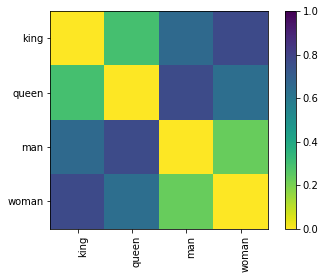

In [15]:
lang_ft[['king', 'queen', 'man', 'woman']].plot_distance()

Notice that man and woman are very similar! Maybe ... don't they just cancel eachother out?

It might be that we just get a little bit of noise that we add to `king`. This is enough noise to make it different, but not enough to move out of the cluster of words that it is in. Note that `queen` and `king` are also really similar upfront as well. When we apply the same operation on `host`-`hostess` we see that it no longer has the same effect.

In [30]:
retreive_most_similar(lang_ft, start="host", positive=["fast"], negative=["slow"], metric='cosine')

,before_word,before_score,after_word,after_score
0,host,0.0000,host,0.2425
1,hosts,0.1629,hosts,0.3770
2,Host,0.3050,Host,0.4762
3,hosting,0.4165,hosting,0.5443
4,hostess,0.4497,hostess,0.5617
5,hosted,0.4601,accommodating,0.6195
6,accommodating,0.5114,guest,0.6208
7,welcoming,0.5263,hosted,0.6252
8,guest,0.5316,welcoming,0.6366
9,gracious,0.5461,presenter,0.6387


In [16]:
retreive_most_similar(lang_ft, start="host", positive=["woman"], negative=["man"], metric='cosine')

,before_word,before_score,after_word,after_score
0,host,0.0000,host,0.2688
1,hosts,0.1629,hosts,0.3679
2,Host,0.3050,Host,0.4748
3,hosting,0.4165,hosting,0.5227
4,hostess,0.4497,hosted,0.5508
5,hosted,0.4601,hostess,0.5527
6,accommodating,0.5114,accommodating,0.6481
7,welcoming,0.5263,welcoming,0.6502
8,guest,0.5316,presenter,0.6825
9,gracious,0.5461,guest,0.6882


In [17]:
retreive_most_similar(lang_ft, start="host", positive=["woman"], negative=["man"], metric='euclidean')

,before_word,before_score,after_word,after_score
0,host,0.0000,host,1.1739
1,hosts,0.7331,hosts,1.3301
2,Host,1.0875,hosting,1.5088
3,hosting,1.0878,hostess,1.5382
4,hostess,1.1257,hosted,1.5421
5,hosted,1.1468,Host,1.5554
6,welcoming,1.1805,welcoming,1.6080
7,accommodating,1.1942,accommodating,1.6185
8,gracious,1.1973,presenter,1.6318
9,presenter,1.2118,responsive,1.6433


It seems like we're not hitting the same "analogy" here because host and hostess were very different from eachother before. 

## Cluster Theory 

I'll try to draw what might be happening here with another example.

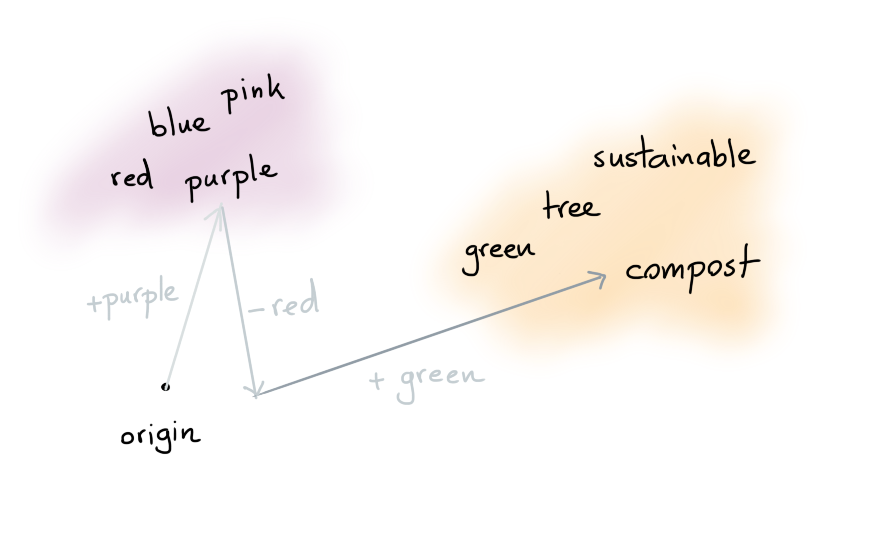

# Another Example 

Let's now consider another example. Now we'll do `purple - red + green`. 

But what happens when we add `green`? 

In [20]:
retreive_most_similar(lang_ft, start="purple", negative=["red"], positive=["green"], metric='cosine')

,before_word,before_score,after_word,after_score
0,purple,0.0000,compost,0.7421
1,pink,0.1827,greens,0.7434
2,blue,0.1932,sustainable,0.7482
3,red,0.2262,sustainability,0.7498
4,yellow,0.2491,gardening,0.7525
5,orange,0.2856,Sustainable,0.7606
6,green,0.3337,gardens,0.7661
7,turquoise,0.3736,landscaping,0.7848
8,brown,0.3882,environmentally,0.7942
9,grey,0.3962,garden,0.7973


In [21]:
retreive_most_similar(lang_ft, start="purple", negative=["red"], positive=["green"], metric='euclidean')

,before_word,before_score,after_word,after_score
0,purple,0.0000,sustainability,1.3013
1,yellow,0.6363,sustainable,1.3109
2,orange,0.6935,environmentally,1.3252
3,turquoise,0.6994,Sustainable,1.3256
4,colored,0.7546,Sustainability,1.3357
5,lavender,0.7740,landscaping,1.3357
6,coloured,0.7840,Infrastructure,1.3361
7,metallic,0.8018,initiatives,1.3375
8,strawberry,0.8134,development,1.3380
9,fluorescent,0.8160,implementation,1.3410


So what can we say about these arithmetic operations? 

- It feels like a stretch to suggest that it resembles an analogy. Certainly not generally in all word-embeddings out there. It seems more likely like certain words are cancelling eachother and that we end up near the original embedding.
- We need to remember that word embeddings don't learn the "meaning" of a word. Instead they represent how a word is being "used". The word "green" should resemble a color! But, in newspapers, it is commonly used as a term to refer to the environment. The words `love` and `hate` are incredibly similar because they appear in the same cluster, not because they have a similar meaning.